In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as T

from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transformations = T.Compose([T.ToTensor(), T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [4]:
train_set = torchvision.datasets.CIFAR10(root="cifar10", train=True, download=True, transform=transformations)
dev_set = torchvision.datasets.CIFAR10(root="cifar10", train=False, download=True, transform=transformations)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
dev_set = Subset(dev_set, range(0, len(dev_set), 2))
test_set = Subset(dev_set, range(1, len(dev_set), 2))

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
dev_loader = DataLoader(dev_set, batch_size=batch_size)

test_loader = DataLoader(test_set, batch_size=len(test_set))

In [6]:
print("Data Shapes: (train/dev/test)")
print(len(train_set))
print(len(dev_set))
print(len(test_set))

print("Data value range: ")
print((np.min(train_set.data), np.max(train_set.data)))
print("Data Categories: ")
print(train_set.classes)

Data Shapes: (train/dev/test)
50000
5000
2500
Data value range: 
(0, 255)
Data Categories: 
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
x, y = next(iter(test_loader))

print((torch.min(x), torch.max(x)))

(tensor(-1.), tensor(1.))


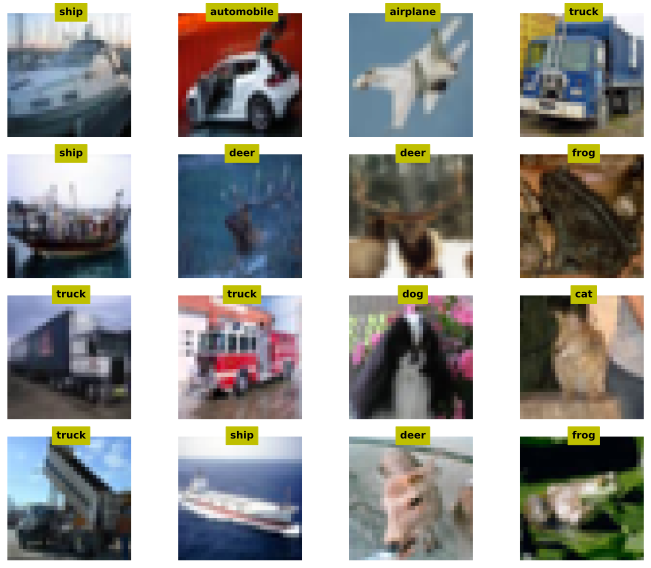

In [8]:
_, axis = plt.subplots(4, 4, figsize=(10, 8))

for(i, ax) in enumerate(axis.flatten()):
    pic = x.data[i].numpy().transpose((1, 2, 0))
    pic = pic/2 + 0.5
    
    label = train_set.classes[y[i]]
    
    ax.imshow(pic)
    ax.text(16, 0, label, ha="center", fontweight="bold", color="k", backgroundcolor="y")
    ax.axis("off")
    
plt.tight_layout();

In [9]:
def model():
    
    class CNN(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
            self.b_norm1 = nn.BatchNorm2d(64)
            
            self.conv2 = nn.Conv2d(64, 128, 3)
            self.b_norm2 = nn.BatchNorm2d(128)
            
            self.conv3 = nn.Conv2d(128, 256, 3)
            self.b_norm3 = nn.BatchNorm2d(256)
            
            self.fc1 = nn.Linear(2*2*256, 256)
            self.fc2 = nn.Linear(256, 64)
            self.out = nn.Linear(64, 10)
        
        def forward(self, x):
            x = self.conv1(x)
            x = f.max_pool2d(x, 2)
            x = self.b_norm1(x)
            x = f.leaky_relu(x)
            
            x = self.conv2(x)
            x = f.max_pool2d(x, 2)
            x = self.b_norm2(x)
            x = f.leaky_relu(x)
            
            x = self.conv3(x)
            x = f.max_pool2d(x, 2)
            x = self.b_norm3(x)
            x = f.leaky_relu(x)
            
            num_units = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(num_units))
            
            x = self.fc1(x)
            x = f.leaky_relu(x)
            x = f.dropout(x, p=0.3, training=self.training)
            
            x = self.fc2(x)
            x = f.leaky_relu(x)
            x = f.dropout(x, p=0.1, training=self.training)
            
            return self.out(x)
        
    cnn = CNN()
    
    loss_fun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, weight_decay=1e-5)
    
    return cnn, loss_fun, optimizer

In [10]:
summary(model()[0].to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 16, 16]             128
            Conv2d-3          [-1, 128, 14, 14]          73,856
       BatchNorm2d-4            [-1, 128, 7, 7]             256
            Conv2d-5            [-1, 256, 5, 5]         295,168
       BatchNorm2d-6            [-1, 256, 2, 2]             512
            Linear-7                  [-1, 256]         262,400
            Linear-8                   [-1, 64]          16,448
            Linear-9                   [-1, 10]             650
Total params: 651,210
Trainable params: 651,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.92
Params size (MB): 2.48
Estimated Total Size (MB): 3.42
-------------------------------------------

In [11]:
def train_model():
    
    num_epochs = 10

    cnn, loss_fun, optimizer = model()
    
    cnn.to(device)
    
    train_loss = []
    dev_loss = []
    train_acc = []
    dev_acc = []
    
    for epoch in range(num_epochs):
        
        batch_loss = []
        batch_acc = []
        
        for x, y in train_loader:
            
            x = x.to(device)
            y = y.to(device)
            
            y_hat = cnn(x)
            loss = loss_fun(y_hat, y)
            
            y_hat = y_hat.cpu()
            y = y.cpu()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            batch_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
            
        train_loss.append(np.mean(batch_loss))
        train_acc.append(np.mean(batch_acc))

        batch_loss = []
        batch_acc = []
        
        cnn.eval()
        
        for x, y in dev_loader:
            x = x.to(device)
            y = y.to(device)
            
            with torch.no_grad():
                y_hat = cnn(x)
                loss = loss_fun(y_hat, y)

            y_hat = y_hat.cpu()
            y = y.cpu()

            batch_loss.append(loss.item())
            batch_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
        
        dev_loss.append(np.mean(batch_loss))
        dev_acc.append(np.mean(batch_acc))
        
    return train_acc, train_loss, dev_acc, dev_loss, cnn, loss_fun

In [12]:
train_acc, train_loss, dev_acc, dev_loss, cnn, loss_fun = train_model()

In [13]:
cnn.eval()

loss_fun = model()[1]

x, y = next(iter(test_loader))
x = x.to(device)
y = y.to(device)

with torch.no_grad():
    y_hat = cnn(x)
    loss = loss_fun(y_hat, y)

y_hat = y_hat.cpu()
y = y.cpu()

test_loss = loss.item()
test_acc = 100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item()

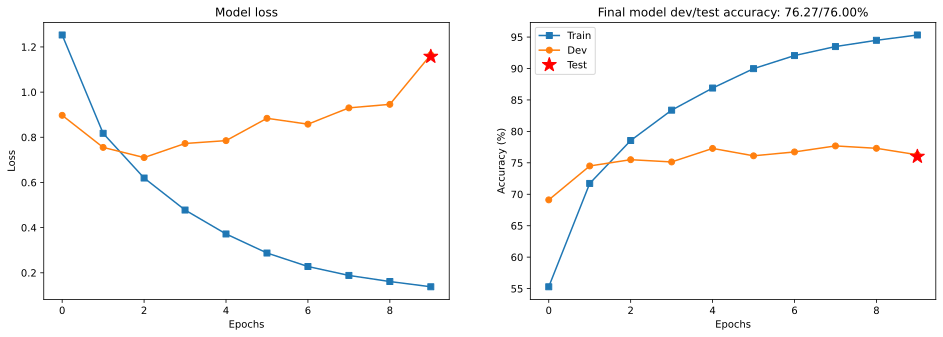

In [14]:
_, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(train_loss, 's-',label='Train')
ax[0].plot(dev_loss, 'o-', label='Dev')
ax[0].plot(len(dev_loss) - 1, test_loss, 'r*', markersize=15, label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(train_acc, 's-', label='Train')
ax[1].plot(dev_acc, 'o-', label='Dev')
ax[1].plot(len(dev_acc) - 1, test_acc, 'r*', markersize=15, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {dev_acc[-1]:.2f}/{test_acc:.2f}%')
ax[1].legend();